## Analogtivation

In [1]:
import keras
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import time
from time import gmtime, strftime

from math import tan, radians
import random
import json

Using TensorFlow backend.
/Users/_Turing/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
# set seeds
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)

### Building a clock

Current Time: 18:16:25


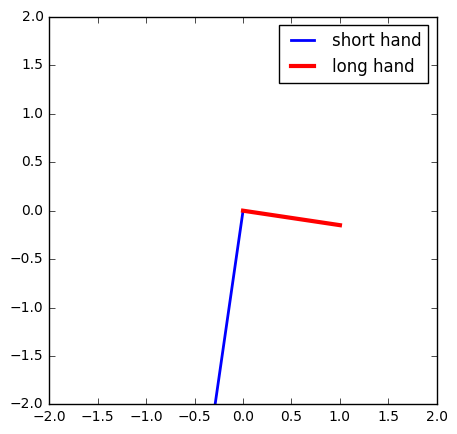

In [3]:
current_time = gmtime()
    
hour   = int(strftime("%H", current_time))
minute = int(strftime("%M", current_time))
second = int(strftime("%S", current_time))
    
# clock starts at 12 (90 degrees) and moves clock-wise
def to_clock_angle(theta):
    return -1 * (theta - 90)
    
exact_hour   = hour%12 + minute/60 + second/(60*60)
exact_minute = minute  + second/60
    
short_hand_angle = to_clock_angle(360 * exact_hour/12)
long_hand_angle  = to_clock_angle(360 * exact_minute/60)

# hand of clock is linear function where slope is equal to tan(angle)
def short_hand(x):
    return tan(radians(short_hand_angle)) * x
def long_hand(x):
    return tan(radians(long_hand_angle)) * x

# plot clock
x_neg = np.linspace(-1, 0, 2)
x_pos = np.linspace(0,  1, 2)

print("Current Time: {}:{}:{}".format(hour, minute, second))
plt.figure(figsize=(5, 5)) 
plt.plot(x_pos             * (exact_hour   < 6.0)  + x_neg             * (exact_hour   >= 6.0), 
         short_hand(x_pos) * (exact_hour   < 6.0)  + short_hand(x_neg) * (exact_hour   >= 6.0),  
         label = "short hand", linewidth = 2, color = "blue")
plt.plot(x_pos             * (exact_minute < 30.0) + x_neg             * (exact_minute >= 30.0), 
         long_hand(x_pos)  * (exact_minute < 30.0) + long_hand(x_neg)  * (exact_minute >= 30.0), 
         label = "long hand",  linewidth = 3, color = "red")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend()
plt.show()

### The activation function

In [4]:
def my_activation(x):
    
    # get current time
    global current_time
    current_time = gmtime()
    
    hour   = int(strftime("%H", current_time))
    minute = int(strftime("%M", current_time))
    second = int(strftime("%S", current_time))
    
    # clock hands
    hour_hand_angle = (hour%12 + minute/60 + second/(60*60)) * 360/12
    hour_hand = tan(radians(to_clock_angle(short_hand_angle)))
    
    minute_hand_angle  = (minute  + second/60) * 360/60
    minute_hand  = tan(radians(to_clock_angle(long_hand_angle)))
    
    # which clock hand do I use?
    above_threshold = minute_hand_angle * x * K.cast(x >= 0.0, "float32") # minute hand for positive
    below_threshold = hour_hand_angle * x * K.cast(x < 0.0, "float32")    # hour hand for negative

    return below_threshold + above_threshold

### Load MNIST Data Set

In [5]:
# Load data
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train.reshape(60000, 28*28).astype('float32') / 255
X_test  = X_test.reshape(10000, 28*28).astype('float32') / 255

y_train = keras.utils.np_utils.to_categorical(y_train, 10)
y_test  = keras.utils.np_utils.to_categorical(y_test, 10)

### Train model

In [6]:
iteration = 1

# run model 24 times
while(iteration < 25):

    # wait 30 minutes
    time.sleep(30 * 60)
    
    # Save the current time at the beginning of every epoch.
    json_log = open('logs/log_'+str(iteration)+'.json', mode='w', buffering=1)
    json_logging_callback = keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: json_log.write(
            json.dumps({'epoch': epoch, 
                        'loss': logs.get('loss'), 
                        'val_loss': logs.get('val_loss'), 
                        'time': strftime("%H:%M:%S", gmtime())}) + '\n'),
        on_train_end=lambda logs: json_log.close()
    )
    
    # Build model
    model = keras.models.Sequential([
        keras.layers.Dense(32, input_shape=(784,), activation = my_activation),
        keras.layers.Dense(10, activation = 'softmax')
    ])

    model.compile(loss = 'categorical_crossentropy', optimizer = 'nadam')

    hist = model.fit(X_train, y_train, 
                     batch_size = 128, epochs = 50, 
                     verbose = 2, validation_data = (X_test, y_test),
                     callbacks = [json_logging_callback])
    
    iteration += 1

KeyboardInterrupt: 